In [5]:
import pycaret
import pandas as pd

In [7]:
# อ่านไฟล์ CSV
data = pd.read_csv('export_data/filtered_data_3_best.csv')

In [8]:
# ตั้ง 'timestamp' เป็น index หากยังไม่ได้ทำ
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# ตั้งค่า freq ให้กับ index
data = data.asfreq('D')  # 'D' สำหรับรายวัน

In [9]:
# แสดงแถวที่มีค่าหายไปก่อนเติม
print("แถวที่มีค่าหายไปก่อนเติม:")
print(data[data.isnull().any(axis=1)])

# เติมค่าที่หายไปด้วยการ interpolate แบบเส้นตรง
data.interpolate(method='linear', inplace=True)

# แสดงแถวที่ยังมีค่า NaN หลังจากเติม (ถ้ามี)
missing_rows_after = data[data.isnull().any(axis=1)]
if not missing_rows_after.empty:
    print("แถวที่ยังมีค่าหายไปหลังเติม:")
    print(missing_rows_after)
else:
    print("ไม่มีค่าหายไปแล้ว")

row = data.loc["2023-09-30 07:00:00"]
row

แถวที่มีค่าหายไปก่อนเติม:
                     humidity  pm_10  pm_2_5  pm_2_5_sp  temperature
timestamp                                                           
2023-09-30 07:00:00       NaN    NaN     NaN        NaN          NaN
ไม่มีค่าหายไปแล้ว


humidity       82.889367
pm_10          60.525519
pm_2_5         53.415241
pm_2_5_sp      69.527667
temperature    29.219760
Name: 2023-09-30 07:00:00, dtype: float64

In [41]:
data = data[['pm_2_5', 'humidity', 'temperature']]

In [42]:
data["year"] = data.index.year
data["month"] = data.index.month
data["day"] = data.index.day
data["day_of_week"] = data.index.dayofweek  # 0 = Monday, 6 = Sunday
data["week_of_year"] = data.index.isocalendar().week  # ค่าจะเป็น int64

In [43]:
# สมมติว่า data มี index เป็น datetime อยู่แล้ว
def assign_season(month):
    if month in [2, 3, 4]:  # ก.พ. - เม.ย.
        return "summer"        # ฤดูร้อน
    elif month in [5, 6, 7]:  # พ.ค. - ก.ค.
        return "early_rainy"   # ต้นฤดูฝน
    else:  # ส.ค. - ม.ค.
        return "late_rainy"    # ปลายฤดูฝน

season_mapping = {'summer': 0, 'early_rainy': 1, 'late_rainy': 2}
data["season"] = data.index.month.map(assign_season)
data['season'] = data['season'].map(season_mapping)

In [44]:
data['dew_point'] = data['temperature'] - ((100 - data['humidity']) / 5)

In [45]:
data["is_weekend"] = data.index.dayofweek.isin([5, 6]).astype(int)

In [46]:
# อัตราส่วนของอุณหภูมิต่อความชื้น
data["temp_humidity_ratio"] = data["temperature"] / (data["humidity"] + 1)

In [47]:
# ดัชนีความร้อน (Heat Index) หรืออุณหภูมิที่รับรู้
T = data["temperature"]
RH = data["humidity"]

data["heat_index"] = -42.379 + (2.04901523 * T) + (10.14333127 * RH) - (0.22475541 * T * RH) - \
                   (0.00683783 * T**2) - (0.05481717 * RH**2) + (0.00122874 * T**2 * RH) + \
                   (0.00085282 * T * RH**2) - (0.00000199 * T**2 * RH**2)

In [48]:
# ความชื้นสัมพัทธ์เชิงดัชนี
data["rh_index"] = data["humidity"] ** 2 / (data["temperature"] + 1)

In [263]:
# #4. ค่าเฉลี่ยของ Humidity และ Temperature ของวันก่อนหน้า
# df["humidity_prev_day"] = df["humidity"].shift(1)
# df["temperature_prev_day"] = df["temperature"].shift(1)

In [19]:
# import pandas as pd
# import numpy as np

# # สมมุติว่ามี DataFrame data ที่มีข้อมูลอยู่แล้ว

# # เพิ่มฟีเจอร์ day_of_year
# data['day_of_year'] = data['month'] * 30 + data['day']  # คำนวณวันในปี

# # เพิ่มฟีเจอร์ hour_of_day (สมมุติว่าเป็นข้อมูลที่มีชั่วโมง)
# # หากไม่มีข้อมูลชั่วโมงใน data, อาจต้องใส่ฟีเจอร์นี้เพิ่มเติม
# # data['hour_of_day'] = data['hour']

# # เพิ่มฟีเจอร์ is_holiday (สามารถกำหนดเองได้)
# # สมมุติว่าคุณมีรายชื่อวันหยุดในปีนั้นๆ
# # holidays = ['2025-01-01', '2025-12-25']  # ตัวอย่าง
# # data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
# # data['is_holiday'] = data['date'].isin(pd.to_datetime(holidays))

# # เพิ่มฟีเจอร์ month_sin และ month_cos
# data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
# data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# # เพิ่มฟีเจอร์ day_of_week_sin และ day_of_week_cos
# data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
# data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

# # เพิ่มฟีเจอร์ rolling average (ค่าเฉลี่ยเคลื่อนที่)
# data['pm_10_rolling_2'] = data['pm_10'].shift(1).rolling(window=2).mean()  # ค่าเฉลี่ย 2 วันของ PM 10
# data['pm_10_rolling_3'] = data['pm_10'].shift(1).rolling(window=3).mean()  # ค่าเฉลี่ย 3 วันของ PM 10
# data['pm_10_rolling_5'] = data['pm_10'].shift(1).rolling(window=5).mean()  # ค่าเฉลี่ย 5 วันของ PM 10
# data['pm_10_rolling_7'] = data['pm_10'].shift(1).rolling(window=7).mean()  # ค่าเฉลี่ย 7 วันของ PM 10

# data['pm_10_lag_1'] = data['pm_10'].shift(1)
# data['pm_10_lag_2'] = data['pm_10'].shift(2)
# data['pm_10_lag_3'] = data['pm_10'].shift(3)
# data['pm_10_lag_5'] = data['pm_10'].shift(5)
# data['pm_10_lag_7'] = data['pm_10'].shift(7)

# data['humidity_rolling_2'] = data['humidity'].shift(1).rolling(window=2).mean()  # ค่าเฉลี่ย 2 วันของ PM 10
# data['humidity_rolling_3'] = data['humidity'].shift(1).rolling(window=3).mean()  # ค่าเฉลี่ย 3 วันของ PM 10
# data['humidity_rolling_5'] = data['humidity'].shift(1).rolling(window=5).mean()  # ค่าเฉลี่ย 5 วันของ PM 10
# data['humidity_rolling_7'] = data['humidity'].shift(1).rolling(window=7).mean()  # ค่าเฉลี่ย 7 วันของ PM 10

# data['humidity_lag_1'] = data['humidity'].shift(1)
# data['humidity_lag_2'] = data['humidity'].shift(2)
# data['humidity_lag_3'] = data['humidity'].shift(3)
# data['humidity_lag_5'] = data['humidity'].shift(5)
# data['humidity_lag_7'] = data['humidity'].shift(7)

# data['temperature_rolling_2'] = data['temperature'].shift(1).rolling(window=2).mean()  # ค่าเฉลี่ย 2 วันของ PM 10
# data['temperature_rolling_3'] = data['temperature'].shift(1).rolling(window=3).mean()  # ค่าเฉลี่ย 3 วันของ PM 10
# data['temperature_rolling_5'] = data['temperature'].shift(1).rolling(window=5).mean()  # ค่าเฉลี่ย 5 วันของ PM 10
# data['temperature_rolling_7'] = data['temperature'].shift(1).rolling(window=7).mean()  # ค่าเฉลี่ย 7 วันของ PM 10

# data['temperature_lag_1'] = data['temperature'].shift(1)
# data['temperature_lag_2'] = data['temperature'].shift(2)
# data['temperature_lag_3'] = data['temperature'].shift(3)
# data['temperature_lag_5'] = data['temperature'].shift(5)
# data['temperature_lag_7'] = data['temperature'].shift(7)

# data.dropna(subset=["pm_10_last_week"], inplace=True)  # ลบแถวที่ไม่มีค่า PM2.5 Last Week
# # data['humidity_rolling'] = data['humidity'].rolling(window=5).mean()  # ค่าเฉลี่ย 7 วันของความชื้น
# # data['temperature_rolling'] = data['temperature'].rolling(window=5).mean()

# # # ตรวจสอบว่า DataFrame พร้อมใช้งานแล้ว
# # print(data.head())


In [ ]:
import pandas as pd
import numpy as np

# สมมุติว่ามี DataFrame data ที่มีข้อมูลอยู่แล้ว

# เพิ่มฟีเจอร์ day_of_year
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
data['day_of_year'] = data['date'].dt.dayofyear

# เพิ่มฟีเจอร์ hour_of_day (สมมุติว่าเป็นข้อมูลที่มีชั่วโมง)
# หากไม่มีข้อมูลชั่วโมงใน data, อาจต้องใส่ฟีเจอร์นี้เพิ่มเติม
# data['hour_of_day'] = data['hour']

# เพิ่มฟีเจอร์ is_holiday (สามารถกำหนดเองได้)
# สมมุติว่าคุณมีรายชื่อวันหยุดในปีนั้นๆ
# holidays = ['2025-01-01', '2025-12-25']  # ตัวอย่าง
# data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
# data['is_holiday'] = data['date'].isin(pd.to_datetime(holidays))

# เพิ่มฟีเจอร์ month_sin และ month_cos
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# เพิ่มฟีเจอร์ day_of_week_sin และ day_of_week_cos
data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

# เพิ่มฟีเจอร์ rolling average (ค่าเฉลี่ยเคลื่อนที่)
# data['pm_2_5_rolling_7'] = data['pm_2_5'].rolling(window=7).mean().shift(1)
# data['pm_2_5_rolling_10'] = data['pm_2_5'].rolling(window=10).mean().shift(1)
# data['pm_2_5_rolling_14'] = data['pm_2_5'].rolling(window=14).mean().shift(1)
# data['pm_2_5_rolling_18'] = data['pm_2_5'].rolling(window=18).mean().shift(1)
# data['pm_2_5_rolling_20'] = data['pm_2_5'].rolling(window=20).mean().shift(1)
# data['pm_2_5_rolling_24'] = data['pm_2_5'].rolling(window=24).mean().shift(1)
# data['pm_2_5_rolling_30'] = data['pm_2_5'].rolling(window=30).mean().shift(1)

data['pm_2_5_lag_7'] = data['pm_2_5'].shift(7)
data['pm_2_5_lag_10'] = data['pm_2_5'].shift(10)
data['pm_2_5_lag_14'] = data['pm_2_5'].shift(14)
data['pm_2_5_lag_18'] = data['pm_2_5'].shift(18)
data['pm_2_5_lag_20'] = data['pm_2_5'].shift(20)
data['pm_2_5_lag_24'] = data['pm_2_5'].shift(24)
data['pm_2_5_lag_30'] = data['pm_2_5'].shift(30)

data['humidity_rolling_2'] = data['humidity'].rolling(window=2).mean().shift(1)  # ค่าเฉลี่ย 2 วันของ PM 10
data['humidity_rolling_3'] = data['humidity'].rolling(window=3).mean().shift(1)  # ค่าเฉลี่ย 3 วันของ PM 10
data['humidity_rolling_5'] = data['humidity'].rolling(window=5).mean().shift(1)  # ค่าเฉลี่ย 5 วันของ PM 10
data['humidity_rolling_7'] = data['humidity'].rolling(window=7).mean().shift(1)  # ค่าเฉลี่ย 7 วันของ PM 10

data['humidity_lag_1'] = data['humidity'].shift(1)
data['humidity_lag_2'] = data['humidity'].shift(2)
data['humidity_lag_3'] = data['humidity'].shift(3)
data['humidity_lag_5'] = data['humidity'].shift(5)
data['humidity_lag_7'] = data['humidity'].shift(7)

data['temperature_rolling_2'] = data['temperature'].rolling(window=2).mean().shift(1)  # ค่าเฉลี่ย 2 วันของ PM 10
data['temperature_rolling_3'] = data['temperature'].rolling(window=3).mean().shift(1)  # ค่าเฉลี่ย 3 วันของ PM 10
data['temperature_rolling_5'] = data['temperature'].rolling(window=5).mean().shift(1)  # ค่าเฉลี่ย 5 วันของ PM 10
data['temperature_rolling_7'] = data['temperature'].rolling(window=7).mean().shift(1)  # ค่าเฉลี่ย 7 วันของ PM 10

data['temperature_lag_1'] = data['temperature'].shift(1)
data['temperature_lag_2'] = data['temperature'].shift(2)
data['temperature_lag_3'] = data['temperature'].shift(3)
data['temperature_lag_5'] = data['temperature'].shift(5)
data['temperature_lag_7'] = data['temperature'].shift(7)

# data.dropna(subset=["pm_2_5_rolling_30"], inplace=True)  # ลบแถวที่ไม่มีค่า PM2.5 Last Week
# data['humidity_rolling'] = data['humidity'].rolling(window=5).mean()  # ค่าเฉลี่ย 7 วันของความชื้น
# data['temperature_rolling'] = data['temperature'].rolling(window=5).mean()

# # ตรวจสอบว่า DataFrame พร้อมใช้งานแล้ว
# print(data.head())


In [50]:
data["temp_diff"] = data["temperature"].diff()
data["humidity_diff"] = data["humidity"].diff()

In [51]:
data.columns

Index(['pm_2_5', 'humidity', 'temperature', 'year', 'month', 'day',
       'day_of_week', 'week_of_year', 'season', 'dew_point', 'is_weekend',
       'temp_humidity_ratio', 'heat_index', 'rh_index', 'date', 'day_of_year',
       'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
       'pm_2_5_lag_7', 'pm_2_5_lag_10', 'pm_2_5_lag_14', 'pm_2_5_lag_18',
       'pm_2_5_lag_20', 'pm_2_5_lag_24', 'pm_2_5_lag_30', 'humidity_rolling_2',
       'humidity_rolling_3', 'humidity_rolling_5', 'humidity_rolling_7',
       'humidity_lag_1', 'humidity_lag_2', 'humidity_lag_3', 'humidity_lag_5',
       'humidity_lag_7', 'temperature_rolling_2', 'temperature_rolling_3',
       'temperature_rolling_5', 'temperature_rolling_7', 'temperature_lag_1',
       'temperature_lag_2', 'temperature_lag_3', 'temperature_lag_5',
       'temperature_lag_7', 'temp_diff', 'humidity_diff'],
      dtype='object')

In [52]:
data_filtered = data.loc['2023-09':]  # ดึงข้อมูลตั้งแต่กันยายน 2023 เป็นต้นไป

<Axes: xlabel='timestamp'>

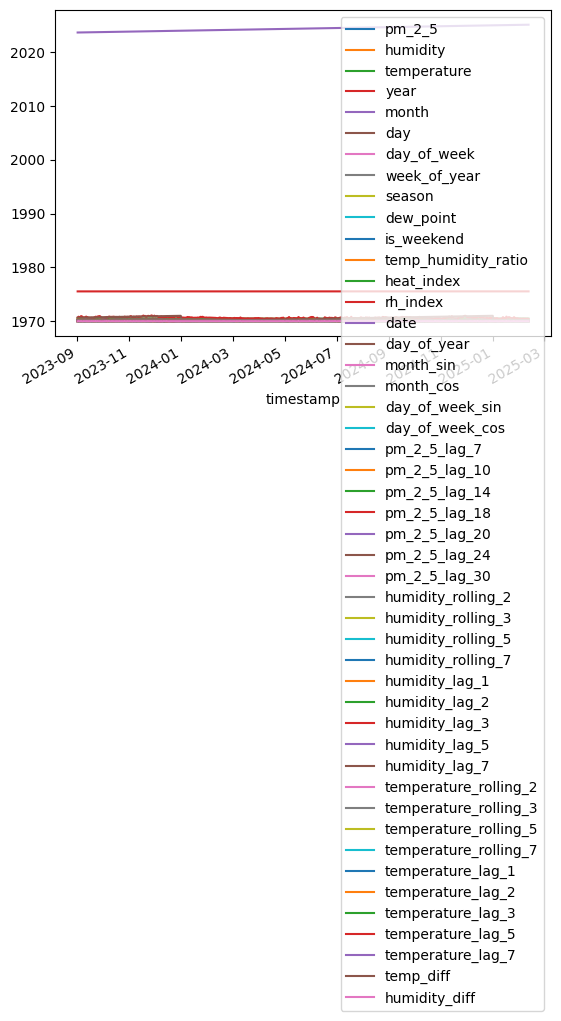

In [24]:
data_filtered.plot()

In [54]:
# สมมติว่า data มีจำนวนวันทั้งหมด
total_data = len(data_filtered)

# จำนวนวันที่ต้องการเป็น test data
test_days = 7

# คำนวณสัดส่วนของ 30 วันในข้อมูลทั้งหมด
test_size = test_days / total_data
test_size

0.013207547169811321

In [55]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data_filtered, test_size=test_size, shuffle=False)

In [56]:
train_data.shape

(523, 47)

In [57]:
test_data.shape

(7, 47)

In [58]:
test_data

,pm_2_5,humidity,temperature,year,month,day,day_of_week,week_of_year,season,dew_point,...,temperature_rolling_3,temperature_rolling_5,temperature_rolling_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_5,temperature_lag_7,temp_diff,humidity_diff
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-02-05 07:00:00,13.987089,71.500943,28.327450,2025,2,5,2,6,0,22.627639,...,28.034622,27.751199,27.644522,27.775432,28.644544,27.683890,27.336718,27.242726,0.552018,1.234421
2025-02-06 07:00:00,19.454865,69.511783,28.579177,2025,2,6,3,6,0,22.481533,...,28.249142,27.949345,27.799482,28.327450,27.775432,28.644544,27.315410,27.512931,0.251727,-1.989160
2025-02-07 07:00:00,29.321219,70.933952,28.271927,2025,2,7,4,6,0,22.458717,...,28.227353,28.202099,27.951803,28.579177,28.327450,27.775432,27.683890,27.336718,-0.307250,1.422170
2025-02-08 07:00:00,26.000000,69.348548,28.385596,2025,2,8,5,6,0,22.255305,...,28.392851,28.319706,28.085404,28.271927,28.579177,28.327450,28.644544,27.315410,0.113669,-1.585405
2025-02-09 07:00:00,24.616898,69.916384,28.373742,2025,2,9,6,6,0,22.357019,...,28.412233,28.267916,28.238288,28.385596,28.271927,28.579177,27.775432,27.683890,-0.011853,0.567837
2025-02-10 07:00:00,25.856981,71.226336,28.251201,2025,2,10,0,7,0,22.496468,...,28.343755,28.387578,28.336838,28.373742,28.385596,28.271927,28.327450,28.644544,-0.122542,1.309951
2025-02-11 07:00:00,27.522727,68.159624,28.693799,2025,2,11,1,7,0,22.325724,...,28.336846,28.372328,28.280646,28.251201,28.373742,28.385596,28.579177,27.775432,0.442598,-3.066711


In [59]:
test_data.tail()

,pm_2_5,humidity,temperature,year,month,day,day_of_week,week_of_year,season,dew_point,...,temperature_rolling_3,temperature_rolling_5,temperature_rolling_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_5,temperature_lag_7,temp_diff,humidity_diff
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-02-07 07:00:00,29.321219,70.933952,28.271927,2025,2,7,4,6,0,22.458717,...,28.227353,28.202099,27.951803,28.579177,28.327450,27.775432,27.683890,27.336718,-0.307250,1.422170
2025-02-08 07:00:00,26.000000,69.348548,28.385596,2025,2,8,5,6,0,22.255305,...,28.392851,28.319706,28.085404,28.271927,28.579177,28.327450,28.644544,27.315410,0.113669,-1.585405
2025-02-09 07:00:00,24.616898,69.916384,28.373742,2025,2,9,6,6,0,22.357019,...,28.412233,28.267916,28.238288,28.385596,28.271927,28.579177,27.775432,27.683890,-0.011853,0.567837
2025-02-10 07:00:00,25.856981,71.226336,28.251201,2025,2,10,0,7,0,22.496468,...,28.343755,28.387578,28.336838,28.373742,28.385596,28.271927,28.327450,28.644544,-0.122542,1.309951
2025-02-11 07:00:00,27.522727,68.159624,28.693799,2025,2,11,1,7,0,22.325724,...,28.336846,28.372328,28.280646,28.251201,28.373742,28.385596,28.579177,27.775432,0.442598,-3.066711


In [60]:
test_data.columns

Index(['pm_2_5', 'humidity', 'temperature', 'year', 'month', 'day',
       'day_of_week', 'week_of_year', 'season', 'dew_point', 'is_weekend',
       'temp_humidity_ratio', 'heat_index', 'rh_index', 'date', 'day_of_year',
       'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
       'pm_2_5_lag_7', 'pm_2_5_lag_10', 'pm_2_5_lag_14', 'pm_2_5_lag_18',
       'pm_2_5_lag_20', 'pm_2_5_lag_24', 'pm_2_5_lag_30', 'humidity_rolling_2',
       'humidity_rolling_3', 'humidity_rolling_5', 'humidity_rolling_7',
       'humidity_lag_1', 'humidity_lag_2', 'humidity_lag_3', 'humidity_lag_5',
       'humidity_lag_7', 'temperature_rolling_2', 'temperature_rolling_3',
       'temperature_rolling_5', 'temperature_rolling_7', 'temperature_lag_1',
       'temperature_lag_2', 'temperature_lag_3', 'temperature_lag_5',
       'temperature_lag_7', 'temp_diff', 'humidity_diff'],
      dtype='object')

In [61]:
# from pycaret.time_series import *
from pycaret.regression import RegressionExperiment
exp1 = RegressionExperiment()
exp1.setup(data=train_data, target='pm_2_5', session_id=123,test_data=test_data, fold=12)

,Description,Value
0,Session id,123
1,Target,pm_2_5
2,Target type,Regression
3,Original data shape,"(530, 47)"
4,Transformed data shape,"(530, 49)"
5,Transformed train set shape,"(523, 49)"
6,Transformed test set shape,"(7, 49)"
7,Numeric features,45
8,Date features,1
9,Preprocess,True


In [62]:
# compare baseline models
best = exp1.compare_models(n_select=17)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,7.2678,88.3394,8.9689,-0.3139,0.4473,0.4767,0.0083
huber,Huber Regressor,7.2605,95.0895,9.2092,-0.3492,0.4438,0.4174,0.0117
llar,Lasso Least Angle Regression,7.4206,91.1784,9.1382,-0.3682,0.4482,0.4735,0.0075
br,Bayesian Ridge,7.4711,93.5795,9.2346,-0.3885,0.4542,0.4785,0.0083
lasso,Lasso Regression,7.4889,93.2539,9.2274,-0.3929,0.4519,0.4743,0.0075
en,Elastic Net,7.5392,94.4965,9.2885,-0.4136,0.4539,0.4733,0.0067
ada,AdaBoost Regressor,7.5020,97.1582,9.4027,-0.4337,0.4638,0.4855,0.0275
et,Extra Trees Regressor,7.6604,99.3984,9.4368,-0.4382,0.4585,0.4827,0.0642
rf,Random Forest Regressor,7.9022,105.4084,9.7129,-0.5228,0.4724,0.5062,0.1392
lightgbm,Light Gradient Boosting Machine,7.8827,105.8726,9.7757,-0.5309,0.4787,0.4846,0.0800


# fold=5
fold = 9 == 0.4985
fold = 10 == 0.4819

In [41]:
# pred_holdout = exp1.predict_model(best)

In [57]:
model_1 = exp1.create_model('huber')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,9.9337,186.2262,13.6465,-0.0693,0.4891,0.3899
1,4.9165,39.1671,6.2584,-0.1982,0.3739,0.3289
2,4.4204,35.2627,5.9382,-0.0150,0.3772,0.3508
3,5.1310,41.0207,6.4047,-0.1006,0.3035,0.2900
4,5.9815,50.3467,7.0955,-0.1053,0.3131,0.2869
5,7.5672,79.1152,8.8947,-0.2305,0.3381,0.3120
6,6.3558,67.7746,8.2325,-0.0320,0.3646,0.3510
7,9.3374,134.6767,11.6050,0.1920,0.3884,0.3388
8,5.2542,43.4606,6.5925,-0.1185,0.4286,0.4426


In [58]:
exp1.evaluate_model(model_1)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [44]:
tune_1 = exp1.tune_model(model_1)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,9.8035,183.8384,13.5587,-0.0556,0.4879,0.3825
1,4.8933,37.9831,6.1630,-0.1620,0.3705,0.3341
2,4.4805,36.1460,6.0122,-0.0404,0.3783,0.3541
3,5.2768,42.0497,6.4846,-0.1282,0.3068,0.2985
4,5.9299,50.9780,7.1399,-0.1191,0.3141,0.2851
5,7.5608,78.3064,8.8491,-0.2179,0.3369,0.3141
6,6.3561,66.6179,8.1620,-0.0144,0.3606,0.3509
7,9.4163,137.4117,11.7223,0.1756,0.3913,0.3422
8,5.3577,43.8858,6.6246,-0.1295,0.4309,0.4563


Fitting 12 folds for each of 10 candidates, totalling 120 fits


In [237]:
model_2 = exp1.create_model('huber')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7.6045,106.9333,10.3409,0.5040,0.3746,0.2903
1,4.9174,36.3848,6.0320,0.1344,0.3446,0.3170
2,3.5527,22.3316,4.7256,0.4824,0.2851,0.2596
3,3.9794,31.6466,5.6255,0.1702,0.2122,0.1613
4,5.5308,49.3324,7.0237,0.2571,0.2784,0.2399
5,5.4526,44.8213,6.6949,0.1745,0.2293,0.1999
6,5.8035,49.5973,7.0425,0.4807,0.2853,0.2813
7,8.6666,137.7561,11.7370,0.3842,0.3556,0.2845
8,5.3115,40.3709,6.3538,0.5623,0.3279,0.3138


In [238]:
blend = exp1.blend_models([model_1, model_2])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7.6045,106.9333,10.3409,0.5040,0.3746,0.2903
1,4.9174,36.3848,6.0320,0.1344,0.3446,0.3170
2,3.5527,22.3316,4.7256,0.4824,0.2851,0.2596
3,3.9794,31.6466,5.6255,0.1702,0.2122,0.1613
4,5.5308,49.3324,7.0237,0.2571,0.2784,0.2399
5,5.4526,44.8213,6.6949,0.1745,0.2293,0.1999
6,5.8035,49.5973,7.0425,0.4807,0.2853,0.2813
7,8.6666,137.7561,11.7370,0.3842,0.3556,0.2845
8,5.3115,40.3709,6.3538,0.5623,0.3279,0.3138


In [239]:
tune = exp1.tune_model(blend)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7.6045,106.9333,10.3409,0.5040,0.3746,0.2903
1,4.9174,36.3848,6.0320,0.1344,0.3446,0.3170
2,3.5527,22.3316,4.7256,0.4824,0.2851,0.2596
3,3.9794,31.6466,5.6255,0.1702,0.2122,0.1613
4,5.5308,49.3324,7.0237,0.2571,0.2784,0.2399
5,5.4526,44.8213,6.6949,0.1745,0.2293,0.1999
6,5.8035,49.5973,7.0425,0.4807,0.2853,0.2813
7,8.6666,137.7561,11.7370,0.3842,0.3556,0.2845
8,5.3115,40.3709,6.3538,0.5623,0.3279,0.3138


Fitting 12 folds for each of 10 candidates, totalling 120 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [59]:
new_data = test_data.copy().drop(['pm_2_5'], axis=1)
predictions = exp1.predict_model(model_1, data=new_data)
predictions

,humidity,temperature,year,month,day,day_of_week,week_of_year,season,dew_point,is_weekend,...,temperature_lag_7,pm_2_5_lag_10,pm_2_5_lag_14,pm_2_5_lag_18,pm_2_5_lag_20,pm_2_5_lag_24,pm_2_5_lag_30,temp_diff,humidity_diff,prediction_label
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-02-05 07:00:00,71.500946,28.327450,2025,2,5,2,6,0,22.627638,0,...,27.242725,29.743679,30.311764,16.223141,45.747353,34.025211,13.047897,0.552018,1.234421,28.296040
2025-02-06 07:00:00,69.511780,28.579176,2025,2,6,3,6,0,22.481533,0,...,27.512932,16.447779,39.527901,31.798225,14.060993,42.594631,36.539570,0.251727,-1.989160,25.848803
2025-02-07 07:00:00,70.933952,28.271927,2025,2,7,4,6,0,22.458717,0,...,27.336718,21.580135,40.677910,40.245155,16.223141,51.460606,35.536755,-0.307250,1.422170,25.384842
2025-02-08 07:00:00,69.348549,28.385595,2025,2,8,5,6,0,22.255306,1,...,27.315409,22.697727,15.038596,21.406284,31.798225,42.430233,33.810780,0.113669,-1.585405,24.957176
2025-02-09 07:00:00,69.916382,28.373743,2025,2,9,6,6,0,22.357019,1,...,27.683891,26.160959,29.743679,30.311764,40.245155,45.747353,37.291229,-0.011853,0.567837,24.039467
2025-02-10 07:00:00,71.226334,28.251202,2025,2,10,0,7,0,22.496468,0,...,28.644545,24.003416,16.447779,39.527901,21.406284,14.060993,40.511738,-0.122542,1.309951,21.114939
2025-02-11 07:00:00,68.159622,28.693800,2025,2,11,1,7,0,22.325724,0,...,27.775433,31.669725,21.580135,40.677910,30.311764,16.223141,34.025211,0.442598,-3.066711,22.949702


In [60]:
predict_v = predictions['prediction_label']
predict_v.head(7)

timestamp
2025-02-05 07:00:00    28.296040
2025-02-06 07:00:00    25.848803
2025-02-07 07:00:00    25.384842
2025-02-08 07:00:00    24.957176
2025-02-09 07:00:00    24.039467
2025-02-10 07:00:00    21.114939
2025-02-11 07:00:00    22.949702
Freq: D, Name: prediction_label, dtype: float64

In [62]:
real = test_data['pm_2_5']
real.head(7)

timestamp
2025-02-05 07:00:00    13.987089
2025-02-06 07:00:00    19.454865
2025-02-07 07:00:00    29.321219
2025-02-08 07:00:00    26.000000
2025-02-09 07:00:00    24.616898
2025-02-10 07:00:00    25.856981
2025-02-11 07:00:00    27.522727
Freq: D, Name: pm_2_5, dtype: float64

In [64]:
# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result = pd.concat([predict_v, test_data['pm_2_5']], axis=1)
result.columns = ['Predictions', 'Actual PM2_5']  # ตั้งชื่อคอลัมน์

# ทำนาย 1 วันข้างหน้า ต้องทำนายเผื่อ 2 วัน

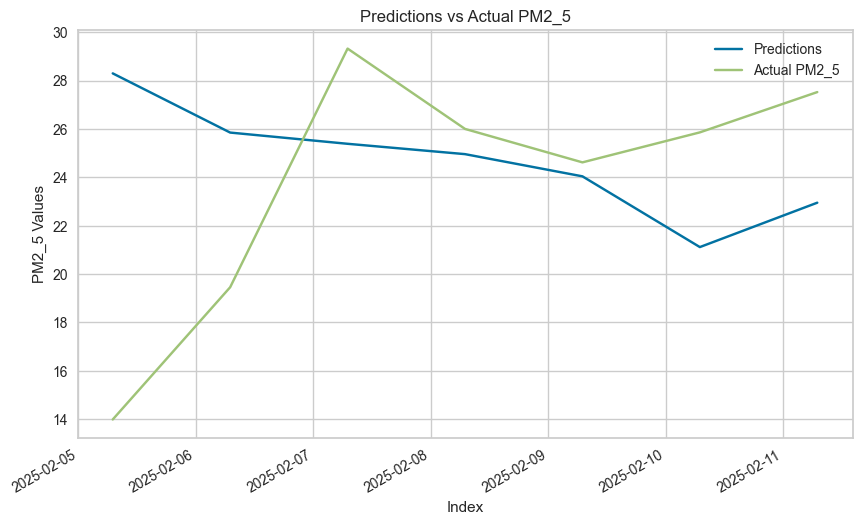

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result = pd.concat([predict_v, test_data['pm_2_5']], axis=1)
result.columns = ['Predictions', 'Actual PM2_5']  # ตั้งชื่อคอลัมน์

# พล็อตข้อมูล
result.plot(figsize=(10, 6))

# ตั้งชื่อกราฟ
plt.title('Predictions vs Actual PM2_5')
plt.xlabel('Index')
plt.ylabel('PM2_5 Values')

# แสดงกราฟ
plt.show()

In [37]:
# import pandas as pd
# from sklearn.metrics import mean_absolute_percentage_error, r2_score

# # สร้าง result จากการ shift ค่าทำนาย
# result = pd.concat([predict_v.shift(-1), test_data['pm_10']], axis=1)
# result.columns = ['predicted', 'actual']

# # ลบแถวที่มีค่า NaN
# result = result.dropna()

# # คำนวณ MAPE
# mape = mean_absolute_percentage_error(result['actual'], result['predicted']) * 100

# # คำนวณ R2
# r2 = r2_score(result['actual'], result['predicted'])

# print(f'MAPE: {mape}%')
# print(f'R²: {r2}')


In [38]:
# MAPE
from itertools import combinations

best_list = list(best)
# เก็บชื่อโมเดลและอ็อบเจกต์ไว้ใน dict
model_names = {model.__class__.__name__: model for model in best_list}

# Dictionary เก็บค่า MAPE
mape_results = {}

loop = 1
# วนลูปเลือกโมเดลทีละคู่
for model1_name, model2_name in combinations(model_names.keys(), 2):
    print(f"{loop} --> Blending: {model1_name} + {model2_name}")  # แสดงว่ากำลังประมวลผลคู่ไหน

    # นำโมเดลทั้งสองมาผสมกัน
    blended_model = exp1.blend_models([model_names[model1_name], model_names[model2_name]], verbose=False)
    
    # ดึงค่าประเมินผลล่าสุด
    result = exp1.pull()
    # ตรวจสอบว่ามีคอลัมน์ 'MAPE' หรือไม่
    if 'MAPE' in result.columns and 'Mean' in result.index:
        mape_value = result.loc['Mean', 'MAPE']
    elif 'R2' in result.columns and 'Mean' in result.index:
        mape_value = result.loc['Mean', 'R2']
    else:
        print(f"❌ ไม่มีค่าที่ต้องการสำหรับ {model1_name} + {model2_name}")
        continue  # ข้ามรอบนี้ถ้าไม่มีค่า MAPE หรือ R2

    # บันทึกค่าลง dictionary
    mape_results[f"{model1_name}, {model2_name}"] = mape_value

    print('-'* 60)
    loop += 1

1 --> Blending: OrthogonalMatchingPursuit + HuberRegressor
------------------------------------------------------------
2 --> Blending: OrthogonalMatchingPursuit + LassoLars
------------------------------------------------------------
3 --> Blending: OrthogonalMatchingPursuit + Lasso
------------------------------------------------------------
4 --> Blending: OrthogonalMatchingPursuit + ElasticNet
------------------------------------------------------------
5 --> Blending: OrthogonalMatchingPursuit + BayesianRidge
------------------------------------------------------------
6 --> Blending: OrthogonalMatchingPursuit + ExtraTreesRegressor
------------------------------------------------------------
7 --> Blending: OrthogonalMatchingPursuit + Ridge
------------------------------------------------------------
8 --> Blending: OrthogonalMatchingPursuit + RandomForestRegressor
------------------------------------------------------------
9 --> Blending: OrthogonalMatchingPursuit + GradientBoos

In [ ]:
# R2
from itertools import combinations

best_list = list(best)
# เก็บชื่อโมเดลและอ็อบเจกต์ไว้ใน dict
model_names = {model.__class__.__name__: model for model in best_list}

# Dictionary เก็บค่า R2
r2_results = {}

loop = 1
# วนลูปเลือกโมเดลทีละคู่
for model1_name, model2_name in combinations(model_names.keys(), 2):
    print(f"{loop} --> Blending: {model1_name} + {model2_name}")  # แสดงว่ากำลังประมวลผลคู่ไหน

    # นำโมเดลทั้งสองมาผสมกัน
    blended_model = exp1.blend_models([model_names[model1_name], model_names[model2_name]], verbose=False)
    
    # ดึงค่าประเมินผลล่าสุด
    result = exp1.pull()
    
    # ตรวจสอบว่ามีคอลัมน์ 'R2' หรือไม่
    if 'R2' in result.columns and 'Mean' in result.index:
        r2_value = result.loc['Mean', 'R2']
    else:
        print(f"❌ ไม่มีค่า R2 สำหรับ {model1_name} + {model2_name}")
        continue  # ข้ามรอบนี้ถ้าไม่มีค่า R2

    # บันทึกค่าลง dictionary
    r2_results[f"{model1_name}, {model2_name}"] = r2_value

    print('-'* 60)
    loop += 1


1 --> Blending: Lasso + OrthogonalMatchingPursuit
------------------------------------------------------------
2 --> Blending: Lasso + LassoLars
------------------------------------------------------------
3 --> Blending: Lasso + ElasticNet
------------------------------------------------------------
4 --> Blending: Lasso + BayesianRidge
------------------------------------------------------------
5 --> Blending: Lasso + HuberRegressor
------------------------------------------------------------
6 --> Blending: Lasso + Ridge
------------------------------------------------------------
7 --> Blending: Lasso + RandomForestRegressor
------------------------------------------------------------
8 --> Blending: Lasso + ExtraTreesRegressor
------------------------------------------------------------
9 --> Blending: Lasso + GradientBoostingRegressor
------------------------------------------------------------
10 --> Blending: Lasso + AdaBoostRegressor
------------------------------------------

In [39]:
print("\nผลลัพธ์ของการ Blend Models:")
for blend, score in sorted(mape_results.items(), key=lambda x: x[1]):  # เรียงจาก R² สูงสุด
    print(f"{blend}: {score}")


ผลลัพธ์ของการ Blend Models:
HuberRegressor, ElasticNet: 0.39
OrthogonalMatchingPursuit, HuberRegressor: 0.3906
HuberRegressor, Lasso: 0.3909
HuberRegressor, BayesianRidge: 0.3909
HuberRegressor, LassoLars: 0.3914
HuberRegressor, KNeighborsRegressor: 0.3965
HuberRegressor, Ridge: 0.3976
HuberRegressor, GradientBoostingRegressor: 0.4078
HuberRegressor, ExtraTreesRegressor: 0.4095
HuberRegressor, LGBMRegressor: 0.4098
OrthogonalMatchingPursuit, ElasticNet: 0.4119
HuberRegressor, AdaBoostRegressor: 0.4126
ElasticNet, BayesianRidge: 0.4127
OrthogonalMatchingPursuit, BayesianRidge: 0.4128
Lasso, ElasticNet: 0.4128
HuberRegressor, RandomForestRegressor: 0.4132
OrthogonalMatchingPursuit, Lasso: 0.4133
LassoLars, ElasticNet: 0.4134
Lasso, BayesianRidge: 0.4135
OrthogonalMatchingPursuit, LassoLars: 0.414
LassoLars, BayesianRidge: 0.4141
LassoLars, Lasso: 0.4143
OrthogonalMatchingPursuit, Ridge: 0.4163
ElasticNet, KNeighborsRegressor: 0.4174
LassoLars, Ridge: 0.418
Lasso, Ridge: 0.418
ElasticNet

# Predict 1 by 1

In [159]:
data_compare = data_filtered.loc[:'2025-01-12']
result = pd.DataFrame()

start_date = "2025-01-13"
end_date = "2025-2-11"

for date in pd.date_range(start=start_date, end=end_date, freq="D"):
    # Drop columns
    test_1 = data_filtered.drop(columns=['pm_10','pm_10_rolling_2', 'pm_10_rolling_3', 'pm_10_rolling_5',
        'pm_10_rolling_7', 'pm_10_lag_1', 'pm_10_lag_2', 'pm_10_lag_3',
        'pm_10_lag_5', 'pm_10_lag_7'])

    # ดึงวันนี้มา
    test_1 = test_1.loc[str(date.date())]

    # ใส่เข้าไป
    data_compare = pd.concat([data_compare, test_1], axis=0)
    
        # คำนวณ
    data_compare['pm_10_rolling_2'] = data_compare['pm_10'].rolling(window=2).mean().shift(1)  # ค่าเฉลี่ย 2 วันของ PM 10
    data_compare['pm_10_rolling_3'] = data_compare['pm_10'].rolling(window=3).mean().shift(1)  # ค่าเฉลี่ย 3 วันของ PM 10
    data_compare['pm_10_rolling_5'] = data_compare['pm_10'].rolling(window=5).mean().shift(1)  # ค่าเฉลี่ย 5 วันของ PM 10
    data_compare['pm_10_rolling_7'] = data_compare['pm_10'].rolling(window=7).mean().shift(1)

    data_compare['pm_10_lag_1'] = data_compare['pm_10'].shift(1)
    data_compare['pm_10_lag_2'] = data_compare['pm_10'].shift(2)
    data_compare['pm_10_lag_3'] = data_compare['pm_10'].shift(3)
    data_compare['pm_10_lag_5'] = data_compare['pm_10'].shift(5)
    data_compare['pm_10_lag_7'] = data_compare['pm_10'].shift(7)

    # ดึง
    test_1 = (data_compare.loc[str(date.date())]).drop(columns=['pm_10'])
    test_1[['pm_10_rolling_2', 'pm_10_rolling_3', 'pm_10_rolling_5',
        'pm_10_rolling_7', 'pm_10_lag_1', 'pm_10_lag_2', 'pm_10_lag_3',
        'pm_10_lag_5', 'pm_10_lag_7']]
    
    # Drop ทิ้งล่าสุดใน data_compare
    data_compare = data_compare.drop(data_compare.last_valid_index())
    test_1 = test_1[~test_1.index.duplicated(keep='last')]

    # Predict
    predict_test_1 = exp1.predict_model(tune_1, data=test_1)

        # เพิ่มผลทำนายเข้าไปใน data_compare
    data_compare = pd.concat([data_compare, predict_test_1], axis=0)

    # แทนที่ค่าในคอลัมน์ 'pm_10' ในวันที่ '2025-01-13' ด้วยค่าในคอลัมน์ 'prediction_label'
    data_compare.loc[str(date.date()), 'pm_10'] = data_compare.loc[str(date.date()), 'prediction_label']

    # ลบคอลัมน์ 'prediction_label' (หากต้องการแค่ผลทำนาย)
    data_compare = data_compare.drop(columns=['prediction_label'])

    # กรองเอาวันที่ซ้ำกัน (index ซ้ำ) ออกให้เหลือแค่ตัวเดียว
    data_compare = data_compare[~data_compare.index.duplicated(keep='last')]

    # บันทึกลง result
    result = pd.concat([result, predict_test_1], axis=0)

In [160]:
data_compare.tail(30)[['pm_10','pm_10_rolling_2', 'pm_10_rolling_3', 'pm_10_rolling_5',
        'pm_10_rolling_7', 'pm_10_lag_1', 'pm_10_lag_2', 'pm_10_lag_3',
        'pm_10_lag_5', 'pm_10_lag_7']]

,pm_10,pm_10_rolling_2,pm_10_rolling_3,pm_10_rolling_5,pm_10_rolling_7,pm_10_lag_1,pm_10_lag_2,pm_10_lag_3,pm_10_lag_5,pm_10_lag_7
timestamp,,,,,,,,,,
2025-01-13 07:00:00,30.828778,41.958834,42.007254,40.825035,37.159014,38.834334,45.083333,42.104094,39.411902,14.912383
2025-01-14 07:00:00,27.811305,34.831556,38.248815,39.108410,39.432785,30.828778,38.834334,45.083333,38.691514,41.075540
2025-01-15 07:00:00,27.777910,29.320041,32.491472,36.932369,37.537894,27.811305,30.828778,38.834334,42.104094,39.411902
2025-01-16 07:00:00,26.176890,27.794607,28.805997,34.067132,35.875895,27.777910,27.811305,30.828778,45.083333,38.691514
2025-01-17 07:00:00,24.511797,26.977400,27.255368,30.285843,34.088092,26.176890,27.777910,27.811305,38.834334,42.104094
2025-01-18 07:00:00,24.803879,25.344344,26.155532,27.421336,31.574907,24.511797,26.176890,27.777910,30.828778,45.083333
2025-01-19 07:00:00,25.243320,24.657838,25.164189,26.216356,28.677842,24.803879,24.511797,26.176890,27.811305,38.834334
2025-01-20 07:00:00,23.985901,25.023600,24.852999,25.702759,26.736268,25.243320,24.803879,24.511797,27.777910,30.828778
2025-01-21 07:00:00,25.203743,24.614611,24.677700,24.944358,25.758715,23.985901,25.243320,24.803879,26.176890,27.811305


In [163]:
test_data

,pm_10,humidity,temperature,year,month,day,day_of_week,week_of_year,dew_point,is_weekend,...,temperature_rolling_3,temperature_rolling_5,temperature_rolling_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_5,temperature_lag_7,temp_diff,humidity_diff
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-02-11 07:00:00,32.532955,68.159624,28.693799,2025,2,11,1,7,22.325724,0,...,28.336846,28.372328,28.280646,28.251201,28.373742,28.385596,28.579177,27.775432,0.442598,-3.066711


In [170]:
real_data

,pm_10,humidity,temperature,year,month,day,day_of_week,week_of_year,dew_point,is_weekend,...,temperature_rolling_3,temperature_rolling_5,temperature_rolling_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_5,temperature_lag_7,temp_diff,humidity_diff
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-13 07:00:00,48.632215,78.292202,25.997341,2025,1,13,0,3,21.655782,0,...,27.579379,28.008569,28.287636,25.434972,28.357459,28.945704,28.921543,28.825509,0.562369,-7.087604
2025-01-14 07:00:00,58.218182,74.887204,26.780883,2025,1,14,1,3,21.758324,0,...,26.596591,27.423728,27.883612,25.997341,25.434972,28.357459,28.383165,29.145097,0.783542,-3.404998
2025-01-15 07:00:00,46.750000,74.201402,27.146722,2025,1,15,2,3,21.987002,0,...,26.071065,27.103272,27.545867,26.780883,25.997341,25.434972,28.945704,28.921543,0.365839,-0.685802
2025-01-16 07:00:00,51.154312,89.873425,24.990604,2025,1,16,3,3,22.965289,0,...,26.641649,26.743476,27.292321,27.146722,26.780883,25.997341,28.357459,28.383165,-2.156118,15.672023
2025-01-17 07:00:00,17.509220,80.848939,27.221665,2025,1,17,4,3,23.391453,0,...,26.306070,26.070104,26.807669,24.990604,27.146722,26.780883,25.434972,28.945704,2.231061,-9.024486
2025-01-18 07:00:00,20.454545,83.512677,26.832436,2025,1,18,5,3,23.534972,1,...,26.452997,26.427443,26.561378,27.221665,24.990604,27.146722,25.997341,28.357459,-0.389229,2.663738
2025-01-19 07:00:00,35.741685,85.338095,25.598781,2025,1,19,6,3,22.666400,1,...,26.348235,26.594462,26.343518,26.832436,27.221665,24.990604,26.780883,25.434972,-1.233655,1.825418
2025-01-20 07:00:00,44.953250,84.719634,26.357235,2025,1,20,0,4,23.301161,0,...,26.550961,26.358042,26.366919,25.598781,26.832436,27.221665,27.146722,25.997341,0.758453,-0.618461
2025-01-21 07:00:00,25.172840,72.150981,28.367937,2025,1,21,1,4,22.798133,0,...,26.262817,26.200144,26.418332,26.357235,25.598781,26.832436,24.990604,26.780883,2.010702,-12.568653


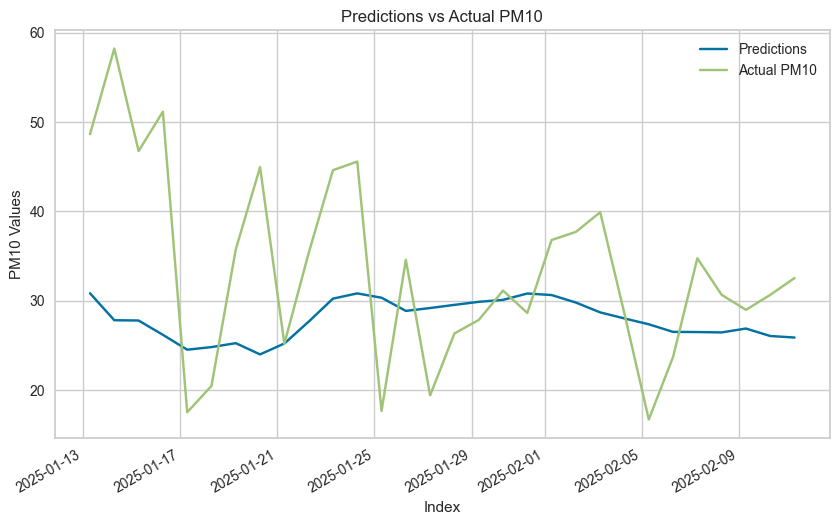

In [169]:
import pandas as pd
import matplotlib.pyplot as plt

real_data = data_filtered.loc[start_date:end_date]
# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result_plot = pd.concat([result['prediction_label'], real_data['pm_10']], axis=1)
result_plot.columns = ['Predictions', 'Actual PM10']  # ตั้งชื่อคอลัมน์

# พล็อตข้อมูล
result_plot.plot(figsize=(10, 6))

# ตั้งชื่อกราฟ
plt.title('Predictions vs Actual PM10')
plt.xlabel('Index')
plt.ylabel('PM10 Values')

# แสดงกราฟ
plt.show()

In [ ]:
print